In [7]:
from cgeniepy.foram import ForamModel as fm, scd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from cgeniepy.grid import GENIE_lat
import numpy as np

def dissimilarity(xmodel, xtime, ymodel=None, ytime=None):

    if not ymodel:
        print("Detecting the same model")
        ymodel = xmodel

    # to avoid "if not zero = True"
    if not ytime and ytime != 0:
        print("Detecting the same time")
        ytime = xtime

    foram_names = ["bn", "bs", "sn", "ss"]
    x_assem, y_assem = [],[]

    for i, foram in enumerate(foram_names):
        x_state_foram = fm(xmodel).select_foramtype(foram).relative_abundance().isel(time=xtime)
        y_state_foram = fm(ymodel).select_foramtype(foram).relative_abundance().isel(time=ytime)
        x_assem.append(x_state_foram.pure_array())
        y_assem.append(y_state_foram.pure_array())

    # calculate squared chord distance for each model
    assemblage_1 = np.array(x_assem)
    assemblage_2 = np.array(y_assem)
    return scd(assemblage_1, assemblage_2)

# PCA analysis > optimal niche

(ecdf) Distribution of data, remove 0 and 1

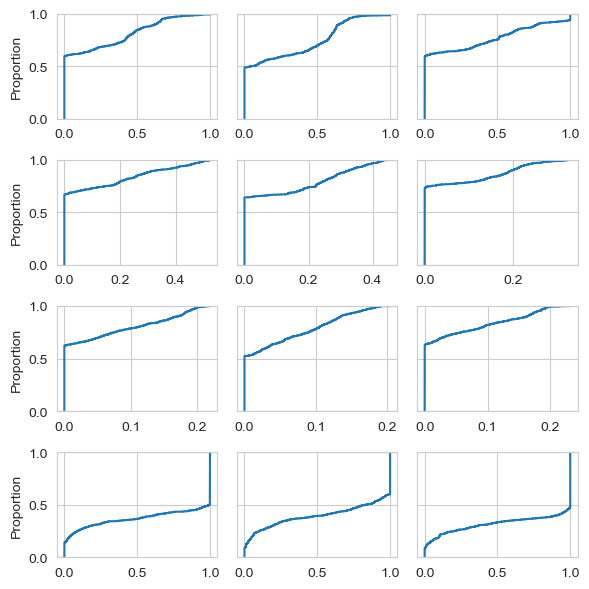

In [47]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(6, 6),
                        tight_layout=True,
                        sharey=True)

foram = ["bn", "bs", "sn", "ss"]
mod_paths = [
    "../model/LGM_8P7Z4F_gmd",
    "../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]


counter = 0
for j in foram:
    for i in mod_paths:
        data = fm(i).select_foramtype(j).relative_abundance().isel(time=-1)
        sns.ecdfplot(data.array.values.ravel(), ax=axs.flat[counter])
        counter += 1

In [43]:
lat = GENIE_lat() * -1
lat_array = np.broadcast_to(lat, (36, 36)).T


mod_paths = ["../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
             "../model/LGM_8P7Z4F_gmd",
             "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
             ]

export_files= ["../data/modern_4pca.csv",
               "../data/lgm_4pca.csv",
               "../data/future1p5_4pca.csv",
               "../data/future2_4pca.csv",
               "../data/future3_4pca.csv",
               "../data/future4_4pca.csv",
               ]

for path, csv_name in zip(mod_paths, export_files):
    mod = fm(path)
    bn = mod.select_foram("bn").relative_abundance().isel(time=-1).array.values.ravel()
    bs = mod.select_foram("bs").relative_abundance().isel(time=-1).array.values.ravel()
    sn = mod.select_foram("sn").relative_abundance().isel(time=-1).array.values.ravel()
    ss = mod.select_foram("ss").relative_abundance().isel(time=-1).array.values.ravel()

    sst = mod.select_var("ocn_sur_temp").isel(time=-1).array.values.ravel()
    sal = mod.select_var("ocn_sur_sal").isel(time=-1).array.values.ravel()
    po4 = mod.select_var("ocn_sur_PO4").isel(time=-1).array.values.ravel()
    prey = mod.select_var("eco2D_Plankton_C_004").isel(time=-1).array.values.ravel()
    fe = mod.select_var("ocn_sur_TDFe").isel(time=-1).array.values.ravel()

    # masked!
    random_var = mod.select_var("ocn_sur_temp").isel(time=-1).array.values
    mask = np.where(np.isnan(random_var), np.nan, 1)
    ## masked lat
    masked_lat = lat_array * mask


    phys_w = mod.select_var("phys_w").isel(time=-1, zt=1).array
    upwelling_discrete = np.where(phys_w >0, 1, 0)

    # temperature gradient between 283 m and 80 m
    therm_gradient = mod.select_var("phys_w").isel(time=-1, zt=3).array - mod.select_var("phys_w").isel(time=-1, zt=1).array

    df = pd.DataFrame({'bn': bn,
                       'bs': bs,
                       'sn':sn,
                       'ss':ss,
                       'sst': sst,
                       #'sal': sal,
                       'po4': po4,
                       'prey': prey,
                       'fe': fe,
                       "lat": masked_lat.ravel(),
                       "upwelling": upwelling_discrete.ravel(),
                       "stratification": therm_gradient.values.ravel()
                       })

    # drop na
    df = df.dropna()
    df = df.query('bn > 0 & bs > 0 & sn > 0 & ss > 0')
    df = df.query('bn < 1 & bs < 1 & sn < 1 & ss < 1')
    df.to_csv(csv_name)

# standardise
#x_scaled = StandardScaler().fit_transform(df)
#pca = PCA(n_components=2)
#pcs = pca.fit(df)

#pcDF = pd.DataFrame(data = pcs,
#                        columns = ['pc1', 'pc2'])
#pcDF = pd.concat([pcDF , pd.DataFrame(target)] , axis = 1)
#import seaborn as sb
#plot = sb.scatterplot(x=pcDF.iloc[:,0], y=pcDF.iloc[:,1], palette='icefire')

In [ ]:
# plot the optimal niche
# question: relative abundance is removing the effects of nutrient availbility

mod_paths = [
    "../model/LGM_8P7Z4F_gmd",
    "../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

foram = ["bn", "bs", "sn", "ss"]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8),
                        subplot_kw={'projection': ccrs.EckertIV()},
                        tight_layout=True)

counter = 0

for j in foram:
    for i in mod_paths:
        data = fm(i).select_foramtype(j).relative_abundance().isel(time=-1)

        # drop zeros and get 75th percentile
        data_nozero = data.filter(">", 0, overwrite_array=True).filter("<", 1, overwrite_array=True)
        upper_quartile = np.nanpercentile(data_nozero.array, 75)

        # filter data, but read again
        data = fm(i).select_foramtype(j).relative_abundance().isel(time=-1)
        filtered_data = data.filter(">", upper_quartile, overwrite_array=True)

        # plot
        filtered_data.plot_map(ax = axs.flat[counter], cmap="viridis")
        print(f"ploting {j} in {i}, with threshold in {upper_quartile}")
        counter += 1

fig.savefig("../output/optimal_niche_distribution.jpg", dpi=400)

# Dissimilarity between 2100 and 1760

<AxesSubplot: xlabel='Temperature', ylabel='Dissimilarity'>

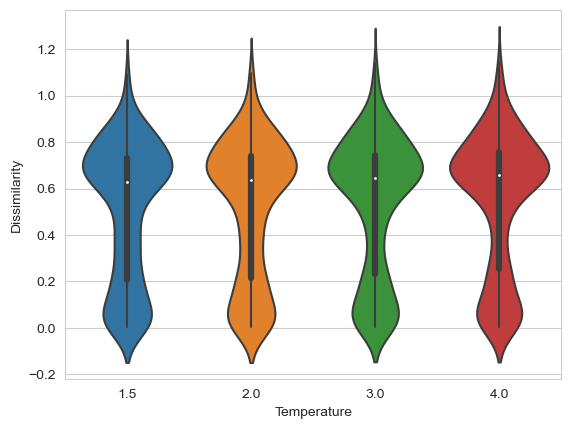

In [12]:
mod_paths = [
             "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
             ]

data = []

# Final year (2100) dissimilarity
for ipath in mod_paths:
    dis = dissimilarity(ipath, xtime=0, ytime=-1)
    data.append(dis)

d = pd.DataFrame({"1.5": data[0].pure_array().ravel(),
                  "2": data[1].pure_array().ravel(),
                  "3": data[2].pure_array().ravel(),
                  "4": data[3].pure_array().ravel()
                  })

d = pd.melt(d, value_vars=['1.5', '2', '3', '4'], var_name="Temperature", value_name='Dissimilarity')
d = d.astype("float")
sns.violinplot(data=d, x="Temperature", y="Dissimilarity", native_scale=True)

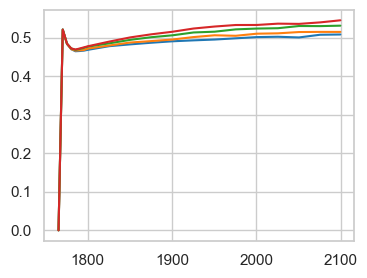

In [62]:
# Cumulative dissimilarity
sns.set_theme()
sns.set_style("whitegrid")
colors = sns.color_palette("tab10", 4)

dtemp = ["1.5", "2", "3", "4"]
for i, ipath in enumerate(mod_paths):
    mean, sd = [], []
    time_label = fm(ipath).select_var("time").array.values
    for j in range(len(time_label)):
        mean.append(dissimilarity(ipath, j).nanmean())
        sd.append(dissimilarity(ipath, j).nansd())
    mean = np.array(mean)
    sd = np.array(sd)
    plt.plot(time_label, mean, label=dtemp[i], color=colors[i])
    #plt.plot(time_label, mean - sd, "--", label=dtemp[i], color=colors[i])
    #plt.plot(time_label, mean + sd, "--", label=dtemp[i], color=colors[i])
    #plt.fill_between(time_label, mean - sd , mean + sd, alpha=0.2, label=dtemp[i])

Detecting the same model
Detecting the same model
Detecting the same model
Detecting the same model


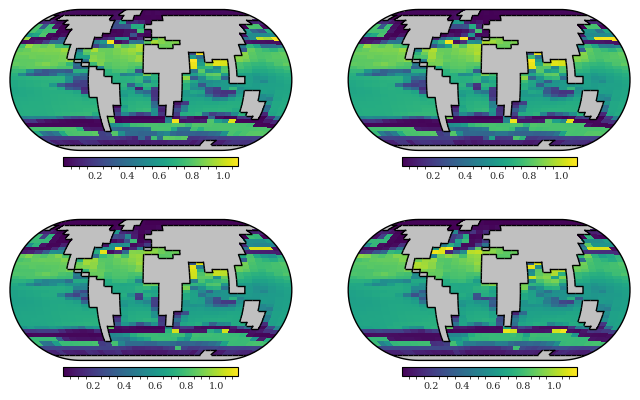

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5),
                        subplot_kw={'projection': ccrs.EckertIV()})

mod_paths = [
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

for i, ipath in enumerate(mod_paths):
    # Functional dispersion
    #foram_community = fm(ipath).select_foram_community("biomass")
    #foram_community.dispersion().plot_map(ax=axs.flat[i], cmap="viridis")

    # dissimilarity
    dissimilarity(ipath, xtime=-1, ytime=0).plot_map(ax=axs.flat[i], cmap="viridis")

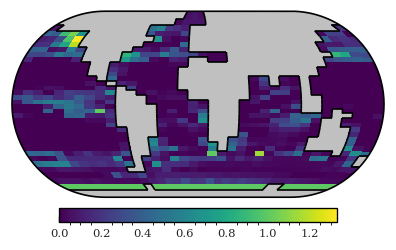

In [13]:
# Total biomass, Compositional changes, Optimal niche, Functional diversity

dissimilarity(xmodel="../model/LGM_8P7Z4F_gmd", xtime=-1,
              ymodel="../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
              ytime=-1).plot_map()

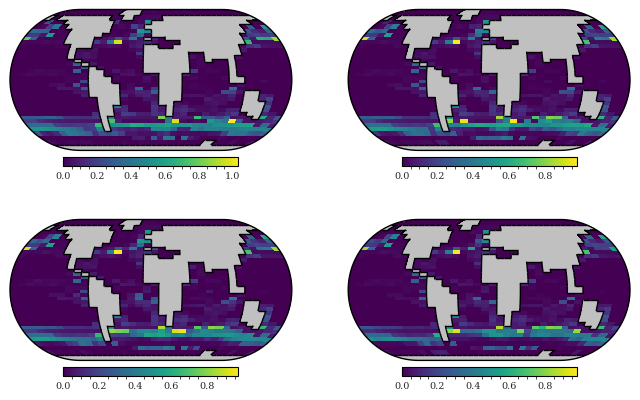

In [44]:
# same temperature, different time

mod_paths = [
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

year = [2099.5, 1999.5, 1919.5, 1879.5]
year_index = [-1, -5, -8, -10]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5),
                        subplot_kw={'projection': ccrs.EckertIV()})

for i, ipath in enumerate(mod_paths):
    # Functional dispersion
    # foram_community = fm(ipath).select_foram_community("biomass")
    # foram_community.dispersion().plot_map(ax=axs.flat[i], cmap="viridis")
    # dissimilarity
    dissimilarity(xmodel=ipath, ymodel="../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
                xtime=year_index[i], ytime=-1).plot_map(ax=axs.flat[i], cmap="viridis")

# Biomass Changes

Total biomass in LGM, PI, and Future

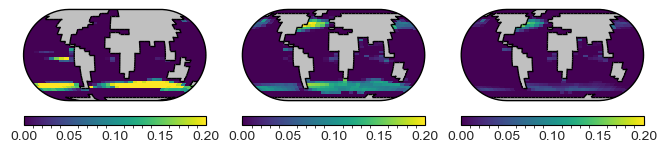

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 5),
                        subplot_kw={'projection': ccrs.EckertIV()})

mod_paths = [
    "../model/LGM_8P7Z4F_gmd",
    "../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
]

for i, ipath in enumerate(mod_paths):
    model = fm(i, ipath).select_foramtype(["bn", "bs","sn","ss"]).biomass(combine_vars=True).take(-1, axis=0)
    model.plot_map(ax=axs.flat[i], vmax=0.2, cmap="viridis")

Text(0, 0.5, 'Foraminifera biomass (Tg)')

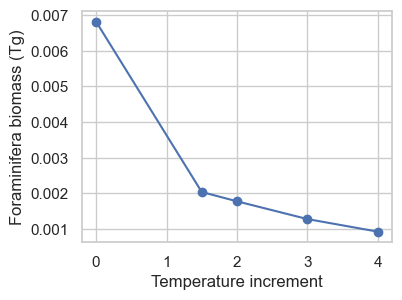

In [115]:
mod_paths = [
    "../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

x_label = [0, 1.5, 2, 3, 4]
y_label = []

for n, i in enumerate(mod_paths):
    a = fm(i).select_foramtype("bn").biomass().isel(time=-1).sum().magnitude
    b = fm(i).select_foramtype("bs").biomass().isel(time=-1).sum().magnitude
    c = fm(i).select_foramtype("sn").biomass().isel(time=-1).sum().magnitude
    d = fm(i).select_foramtype("ss").biomass().isel(time=-1).sum().magnitude

    y = np.array([a, b, c, d])
    y_label.append(y)

y_label = np.array(y_label)
y_label = y_label.sum(axis=1) #sum all foram types

plt.plot(x_label, y_label, marker="o")
plt.xlabel("Temperature increment")
plt.ylabel("Foraminifera biomass (Tg)")

Future time series (not very meaningful because not historical)

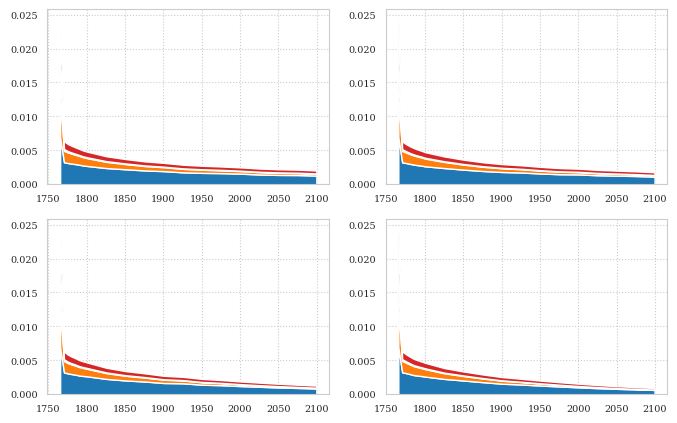

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
mod_paths = [
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

for n, i in enumerate(mod_paths):
    bn, bs, sn, ss = [], [], [], []
    for j in range(20):
        a = fm(i).select_foramtype("bn").biomass().isel(time=j).sum().magnitude
        b = fm(i).select_foramtype("bs").biomass().isel(time=j).sum().magnitude
        c = fm(i).select_foramtype("sn").biomass().isel(time=j).sum().magnitude
        d = fm(i).select_foramtype("ss").biomass().isel(time=j).sum().magnitude

        bn.append(a)
        bs.append(b)
        sn.append(c)
        ss.append(d)
        time = fm(i).select_var("time").array.values
    axs.flat[n].stackplot(time,bn, bs, sn, ss)